In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
from rich import print as pprint
from sourcesep.utils.config import load_config

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [2]:
# These are combined responses of autofluorescence, Ca sensor (EGFP), and DA sensor (mApple).

from sourcesep.sim import SimData
paths = load_config(dataset_key='all')
sim = SimData(T=10000, cfg_path=paths['root'] / "sim_HSFP_670128_2023-04-27.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()
pprint(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     445     473     514     560
EGFP  0.1732  0.3915  0.8143  0.1469  0.0054

In [3]:
paths = load_config(dataset_key='all')
f = h5py.File(paths['root'] / 'HSFP_670128_2023-04-27_data_preprocessed.hdf5', 'r')
print(f.keys())

xj = {}
for j in np.argsort(f['Lasers'][:]):
    xj[j]  = f[f'Channel{j+1}'][:].astype(float)

t = f['Time'][:]
l = f['Wavelength'][:]
lasers = f['Lasers'][:][np.argsort(f['Lasers'][:])]

print(f'\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz')
print(f'length of recording: {np.max(t)-np.min(t):0.2f} seconds')
print(f'\neach channel has dimensions of {xj[0].shape}')
print(f'min. wavelength: {np.min(l):0.2f} nm')
print(f'max. wavelength: {np.max(l):0.2f} nm')

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Lasers', 'Time', 'Wavelength']>

sampling frequency: 23.99 Hz
length of recording: 448.23 seconds

each channel has dimensions of (10752, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


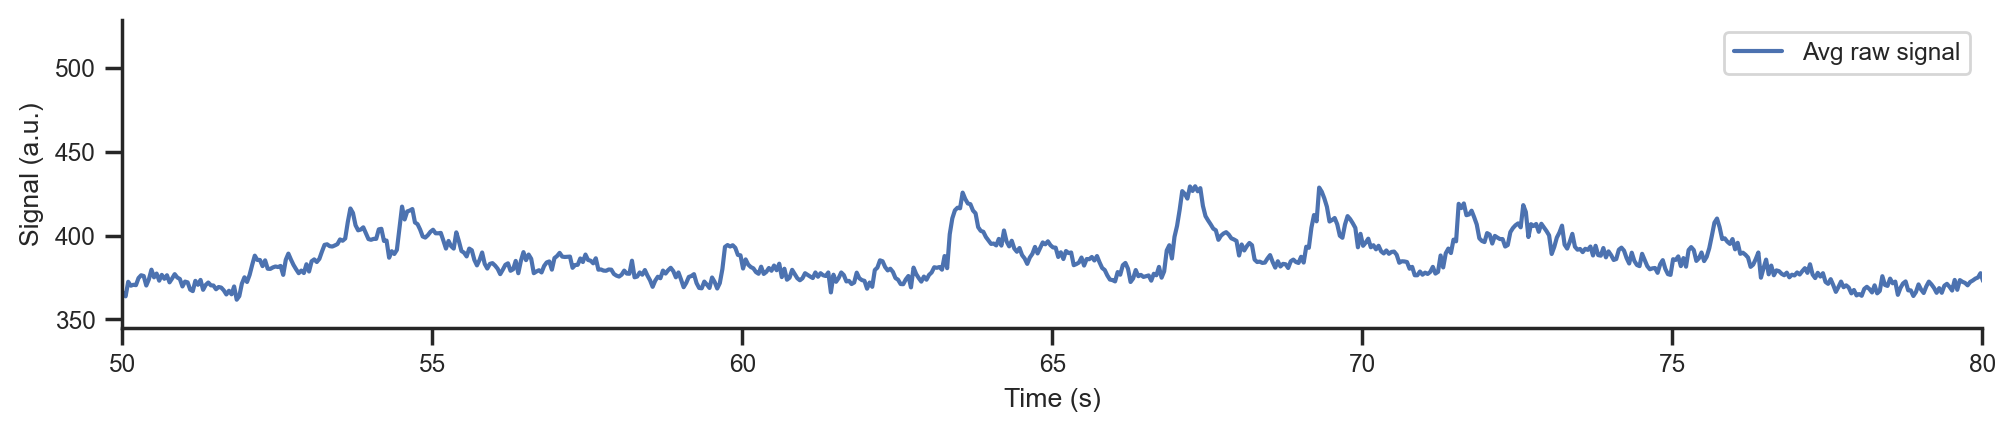

In [4]:
roi = np.where(np.logical_and(l>530, l<540))[0]
avg_roi = np.mean(xj[2][:,roi], axis=1).squeeze()
f, ax = plt.subplots(1,1,figsize = (12,2))
ax.plot(t, avg_roi, '-b', label='Avg raw signal')
ax.set(xlim = (50, 80), xlabel = 'Time (s)', ylabel = 'Signal (a.u.)')
plt.legend()
plt.show()

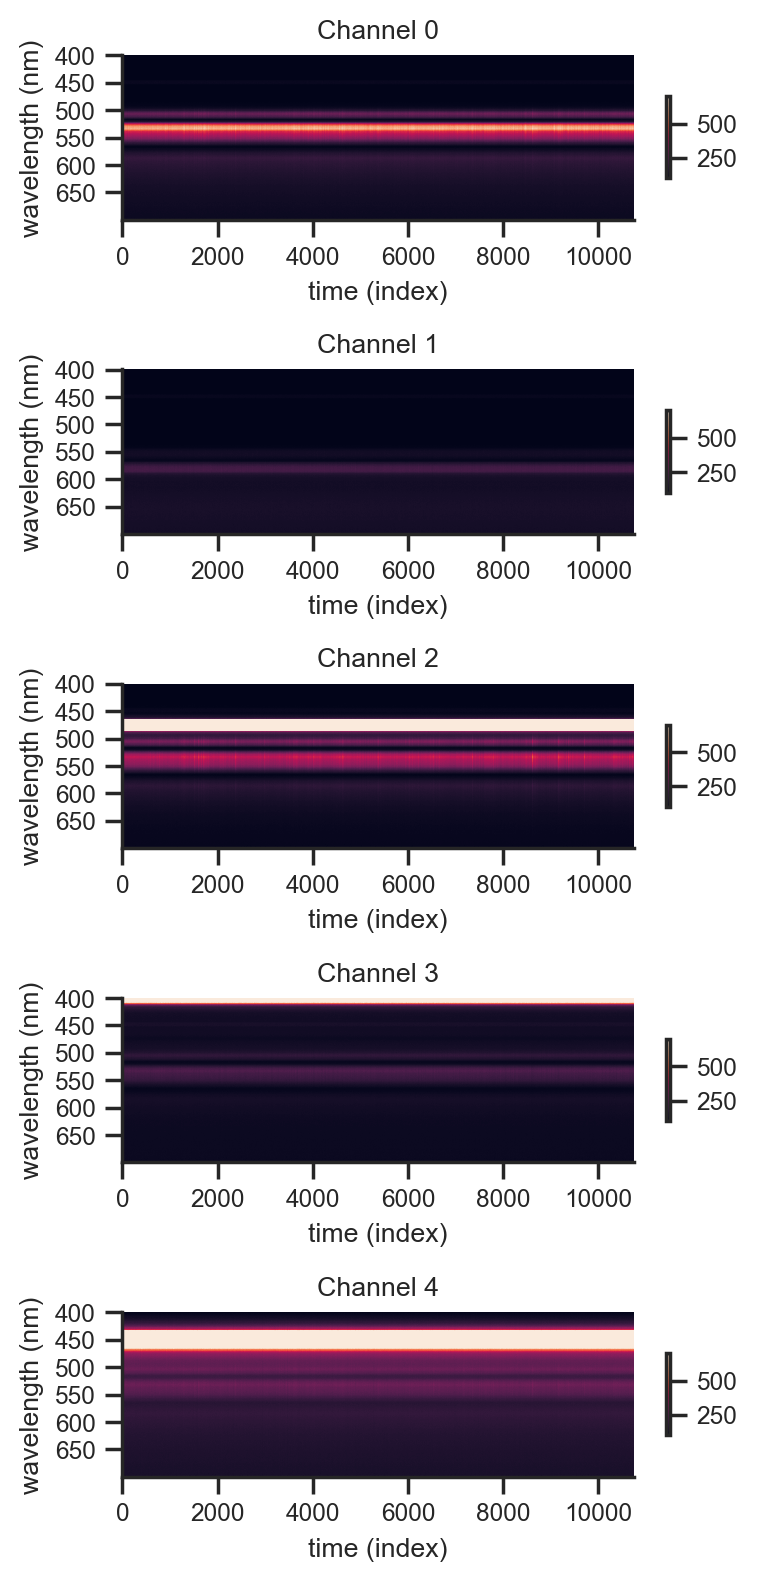

In [5]:
f, ax = plt.subplots(5, 1, figsize=(4, 8))
for j in range(5):
    f.colorbar(ax[j].imshow(xj[j].T, interpolation='nearest', aspect='auto', vmin=100, vmax=700), ax=ax[j], shrink=0.5)
    ax[j].grid(visible=False)
    ax[j].set(ylabel='wavelength (nm)', xlabel='time (index)', title=f'Channel {j}')
    ax[j].set_yticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()

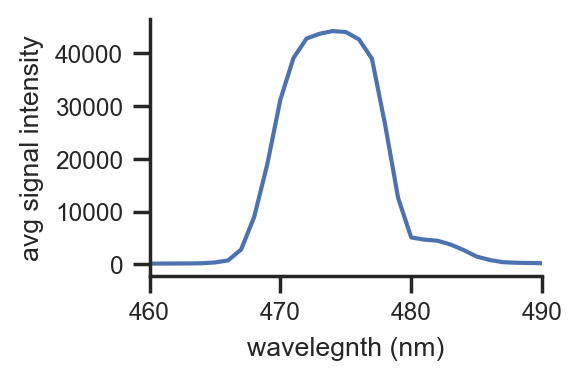

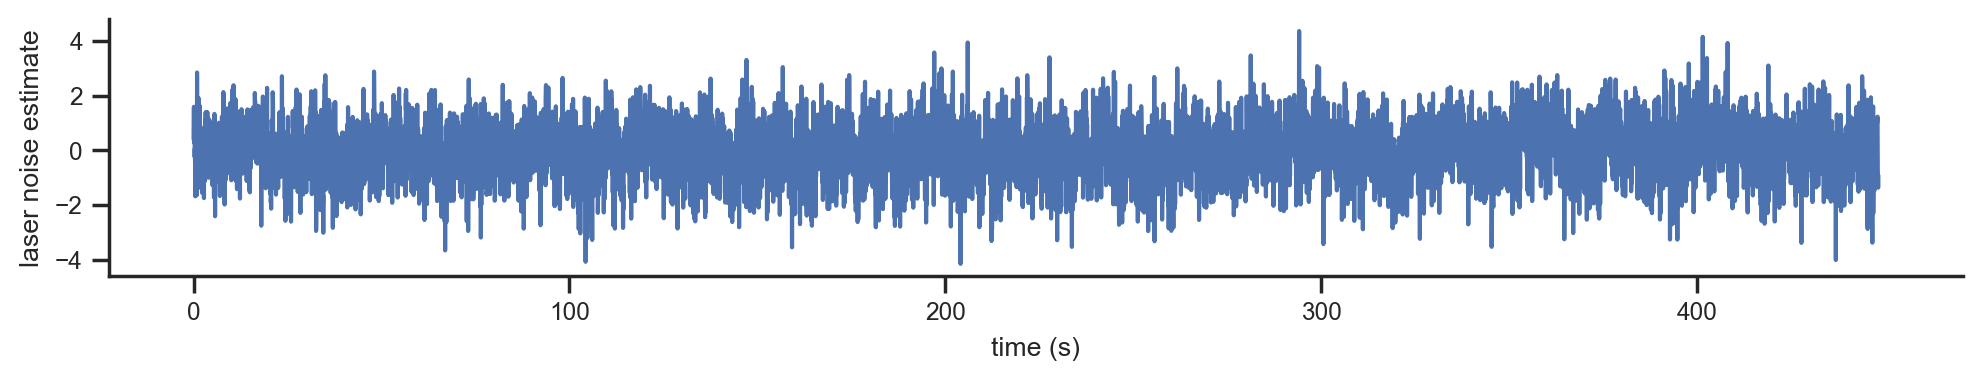

In [6]:
# what is the contribution of laser noise across wavelengths?
f, ax = plt.subplots(1,1, figsize=(3,2))
ax.plot(l, np.mean(xj[2], 0))
ax.set(xlim=(460, 490), xlabel='wavelegnth (nm)', ylabel='avg signal intensity')
plt.tight_layout()
plt.show()

roi = np.where(np.logical_and(l>470, l<477))[0]
laser_noise = np.mean(xj[2][:,roi], 1).squeeze()
laser_noise = laser_noise - np.mean(laser_noise)
laser_noise = laser_noise / np.std(laser_noise)

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(t, laser_noise,'-', label='standardized laser noise est.')
ax.set(xlabel='time (s)', ylabel='laser noise estimate')
plt.tight_layout()
plt.show()

#### Correlation of laser noise for pixels at diffferent wavelengths:

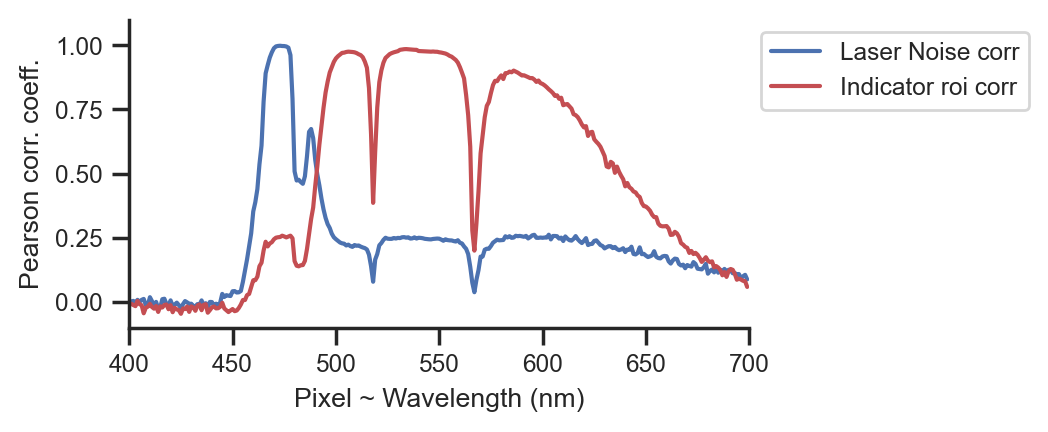

In [7]:

def coef_fn(x,y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x)*np.std(y) + 1e-10)
    return c

laser_cc = np.array([coef_fn(laser_noise, xj[2][:,i]) for i in range(xj[2].shape[1])])
indicator_cc = np.array([coef_fn(avg_roi, xj[2][:,i]) for i in range(xj[2].shape[1])])
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l,laser_cc, '-b', label='Laser Noise corr')
ax.plot(l,indicator_cc, '-r', label='Indicator roi corr')
ax.set(xlim=(400, 700),
       ylim=(-0.1, 1.1),
       xlabel='Pixel ~ Wavelength (nm)',
       ylabel='Pearson corr. coeff.',)
ax.legend(bbox_to_anchor=(1.00, 1.00), loc='upper left')
plt.show()


We assume that the signal at each measured wavelength ${\lambda}$ is a linear combination of laser noise $h_0$ and indicator activity $h_1$.
$$ x^{\lambda}(t) = w^{\lambda}_0 h_0(t) + w^{\lambda}_1 h_1(t) $$

 - $h_0(t)$ can be initialized via the raw signal around `473 nm`.
 - $h_1(t)$ can be initialized via the raw signal around `530 nm`.
 - $ w^{\lambda}_0 $ init. as corr. coef. of laser roi with the signal at each wavelength (pixel).
 - $ w^{\lambda}_1 $ init. as corr. coef. of indicator roi with the signal at each wavelength (pixel).
<p></p>

 - In the raw signal, laser noise is orders of magnitude larger than indicator activity.
 - Normalization is necessary signal at each pixel is important (e.g. by avg signal over time at the pixel)\

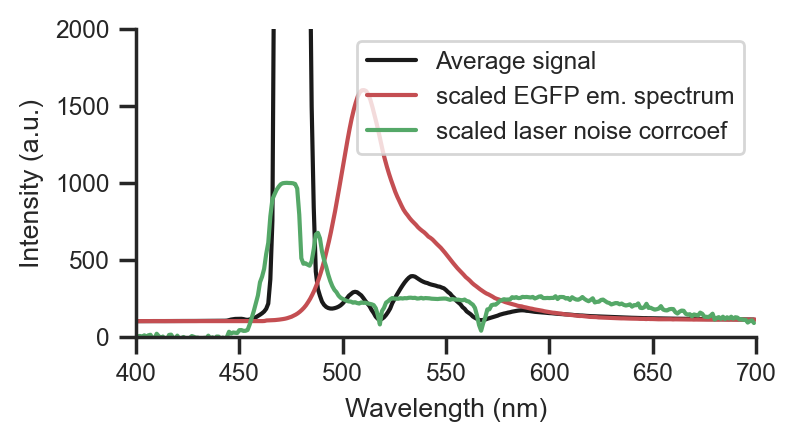

In [8]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
plt.plot(l, np.mean(xj[2], axis=0).squeeze(), '-k', label='Average signal')
plt.plot(sim.L_arr, 100+1500*sim.S.squeeze(), '-r', label='scaled EGFP em. spectrum')
plt.plot(l, 1000*laser_cc, '-g', label='scaled laser noise corrcoef')
ax.set(xlim=(400, 700),
       ylim=(0, 2000),
       xlabel='Wavelength (nm)',
       ylabel='Intensity (a.u.)')
ax.legend()
plt.show()


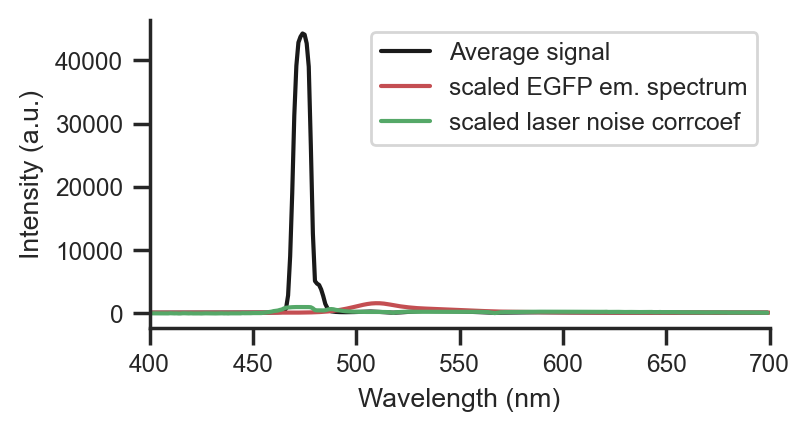

In [9]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
plt.plot(l, np.mean(xj[2], axis=0).squeeze(), '-k', label='Average signal')
plt.plot(sim.L_arr, 100+1500*sim.S.squeeze(), '-r', label='scaled EGFP em. spectrum')
plt.plot(l, 1000*laser_cc, '-g', label='scaled laser noise corrcoef')
ax.set(xlim=(400, 700),
       xlabel='Wavelength (nm)',
       ylabel='Intensity (a.u.)')
ax.legend()
plt.show()

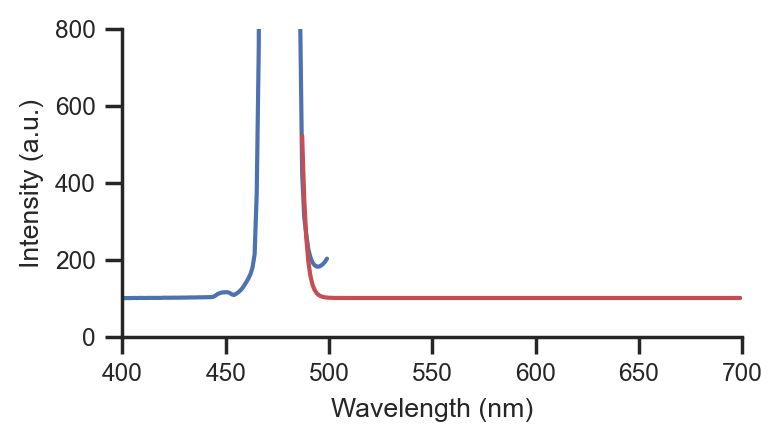

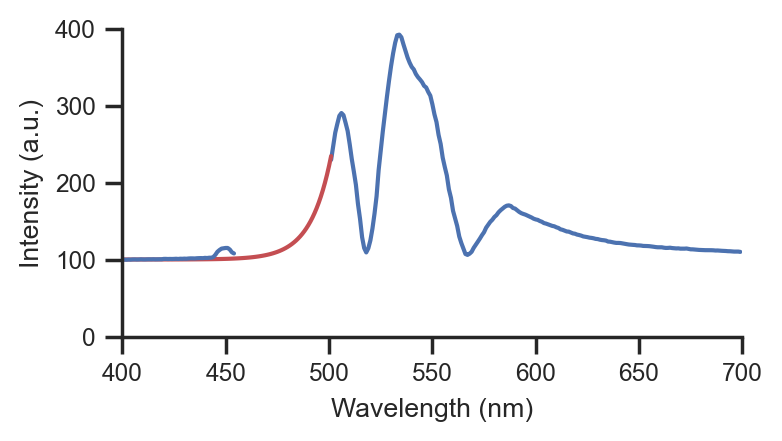

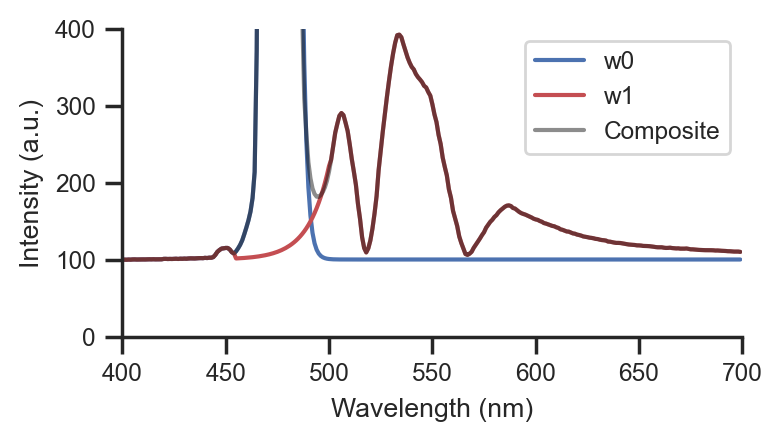

In [10]:
# Heuristically setting spectrum for EGFP and laser in region of overlap
# These will become our initial guesses for the response. 
# Issues with calibration of wavelengths, notch shape etc. is sidestepped for now.

S_composite = np.mean(xj[2], axis=0).squeeze()

fun0 = lambda x: S_composite[l==487]*np.exp(-(x-487)/2) + 100
x = np.arange(487,700)

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l[l < 500], S_composite[l < 500], '-b')
ax.plot(x, fun0(x), '-r')
ax.set(xlim=(400, 700), ylim=(0, 800),
       xlabel='Wavelength (nm)', ylabel='Intensity (a.u.)')
plt.show()

fun1 = lambda x: np.exp((x-452)/10) + 100
x = np.arange(400,502)

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l[l > 500], S_composite[l > 500], '-b')
ax.plot(x, fun1(x), '-r')
ax.plot(l[l < 455], S_composite[l < 455], '-b')
ax.set(xlim=(400, 700), ylim=(0, 400),
       xlabel='Wavelength (nm)', ylabel='Intensity (a.u.)')
plt.show()

w_0 = np.concatenate([S_composite[l < 487], fun0(l[l >= 487])])
w_1 = np.concatenate([S_composite[l < 455],
                      fun1(l[np.logical_and(l >= 455, l <= 500)]),
                      S_composite[l > 500]])
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l, w_0, '-b', label='w0')
ax.plot(l, w_1, '-r', label='w1')
ax.plot(l, S_composite, '-k', alpha=0.5, label='Composite')
ax.set(xlim=(400, 700), ylim=(0, 400),
       xlabel='Wavelength (nm)', ylabel='Intensity (a.u.)')
ax.legend()
plt.show()


In [11]:
# Time for NMF
X = xj[2]
avg_signal = np.mean(X,axis=0)
X = X/avg_signal.reshape(1,-1)
print('X', X.shape)

W_init = np.vstack((laser_cc.reshape(1,-1),indicator_cc.reshape(1,-1)))
W_init = W_init+ 0.2
print('W_init', W_init.shape)

H_init = np.hstack((X[:,l==473].reshape(-1,1),X[:,l==530].reshape(-1,1)))
H_init = H_init/np.mean(H_init,axis=1, keepdims=True)
print('H_init', H_init.shape)

X (10752, 300)
W_init (2, 300)
H_init (10752, 2)


In [12]:
import numpy as np
from sklearn.decomposition import NMF

idx_start = 0
idx_end = 2000
n_components = 2
model = NMF(n_components=n_components, init='custom',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=10000, random_state=None,
            alpha_W=0.0, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

In [13]:
W_fit = model.fit_transform(X.T[:,idx_start:idx_end], W=W_init.T, H=H_init.T[:,idx_start:idx_end])
H_fit = model.components_

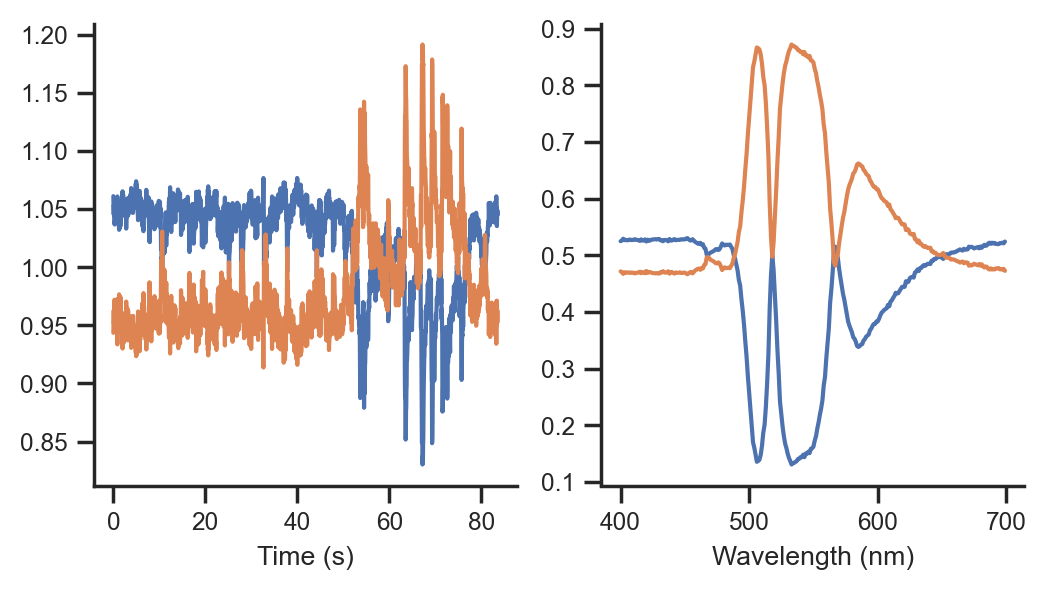

In [14]:
f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(t[idx_start:idx_end], H_fit.T)
ax[0].set(xlabel='Time (s)')

ax[1].plot(l, W_fit)
ax[1].set(xlabel='Wavelength (nm)')
plt.show()

[(0.0, 500.0)]

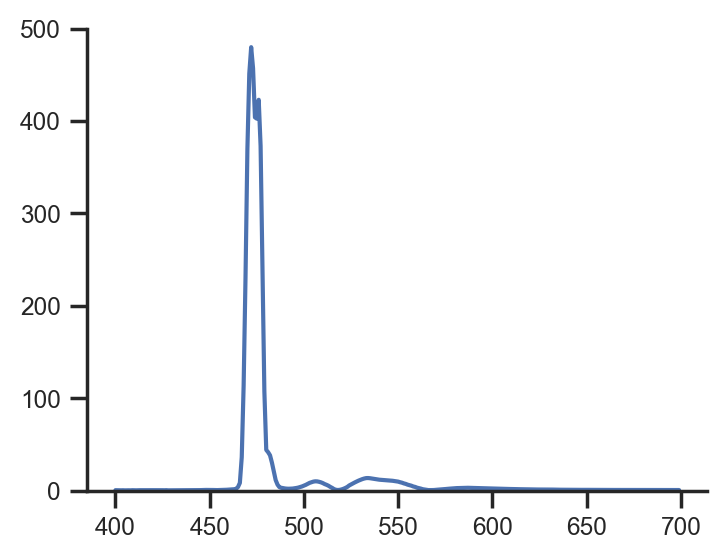

In [15]:
f,ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(l,xj[2].std(0).squeeze())
ax.set(ylim = (0,500))

#### Example NMF with test data

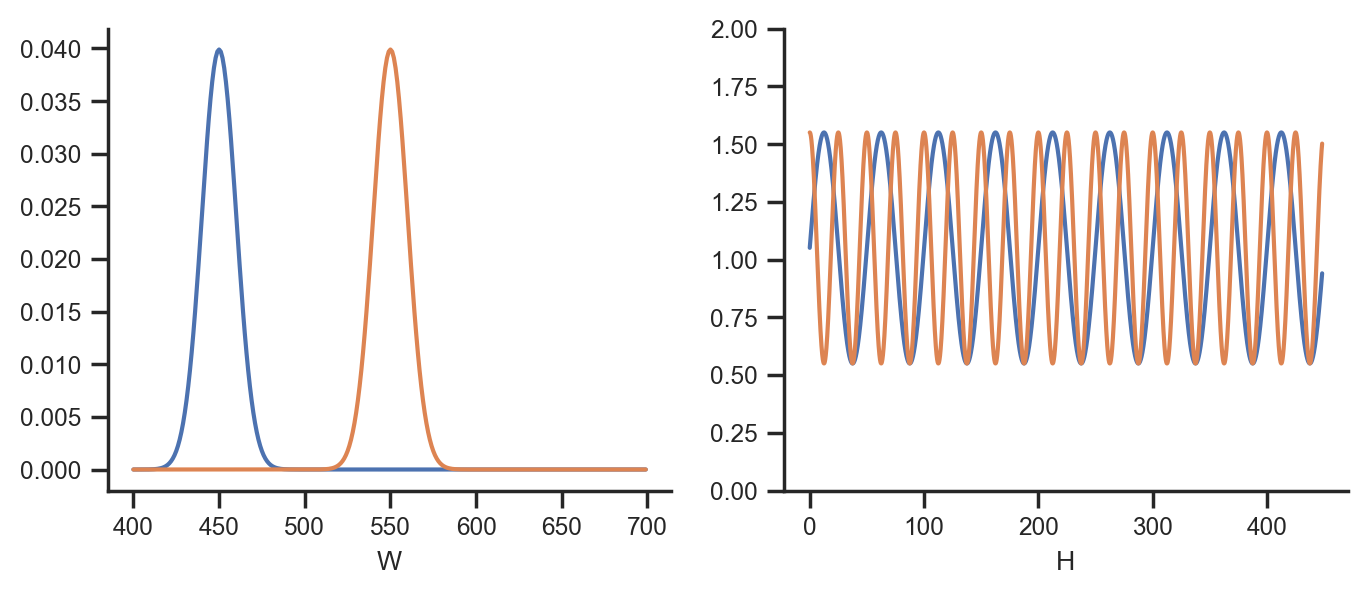

In [16]:

from scipy.stats import norm

W_true = np.concatenate([norm.pdf(l,loc=450, scale=10).reshape(1,-1),
                    norm.pdf(l,loc=550, scale=10).reshape(1,-1)], axis = 0)

H_true = np.concatenate([np.sin(2*np.pi*0.02*t).reshape(-1,1), 
                         np.cos(2*np.pi*0.04*t).reshape(-1,1)], axis=1)
H_true = (H_true+2.1) * 0.5

f, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(l,W_true.T)
ax[0].set(xlabel='W')
ax[1].plot(t, H_true)
ax[1].set(xlabel='H', ylim = (0,2))
plt.show()

In [17]:
X_true = H_true @ W_true
print('W_true:', W_true.shape)
print('H_true:', H_true.shape)
print('X_true:', X_true.shape)

W_true: (2, 300)
H_true: (10752, 2)
X_true: (10752, 300)


In [18]:
model = NMF(n_components=n_components, init='random',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=10000, random_state=None,
            alpha_W=1, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

W_fit = model.fit_transform(X_true.T)
H_fit = model.components_

W_fit = W_fit.T
H_fit = H_fit.T

/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


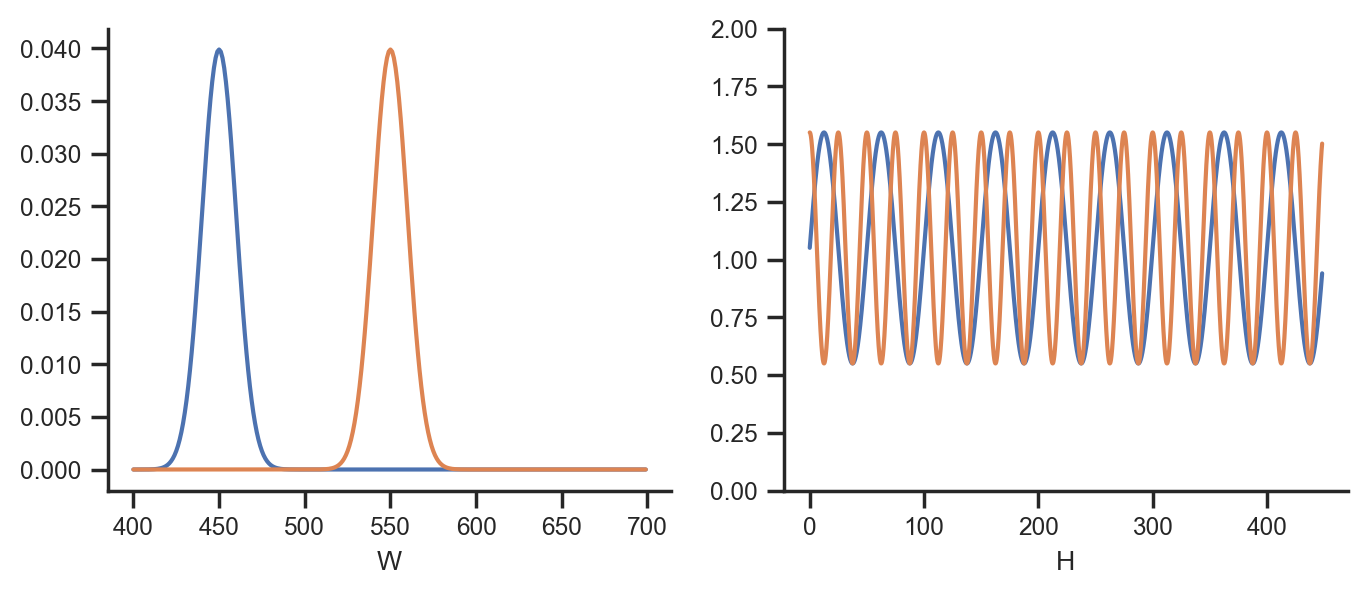

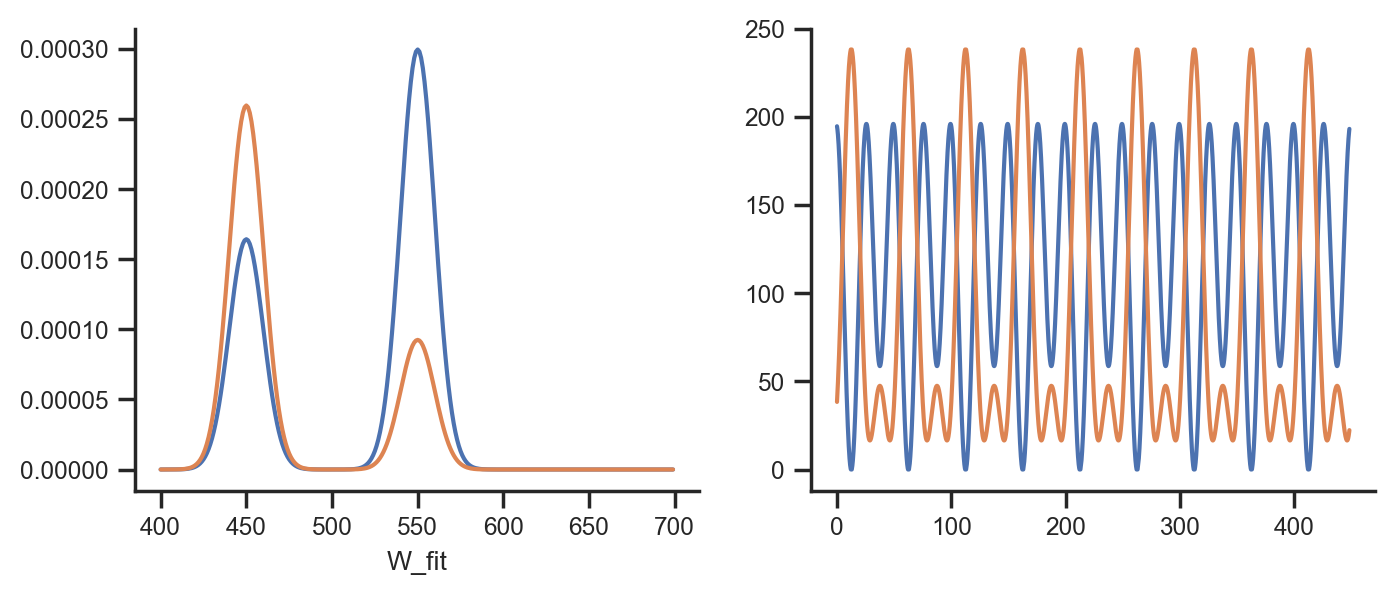

In [19]:
f, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(l,W_true.T)
ax[0].set(xlabel='W')
ax[1].plot(t, H_true)
ax[1].set(xlabel='H', ylim = (0,2))
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(l, W_fit.T)
ax[0].set(xlabel='W_fit')
ax[1].plot(t, H_fit)
plt.show()

In [20]:
err = np.abs((H_fit@W_fit - H_true@W_true))
pltj = [H_true@W_true,H_fit@W_fit,err]
print("Error: ", np.linalg.norm(err, ord='fro'))

Error:  0.0027828071218733235


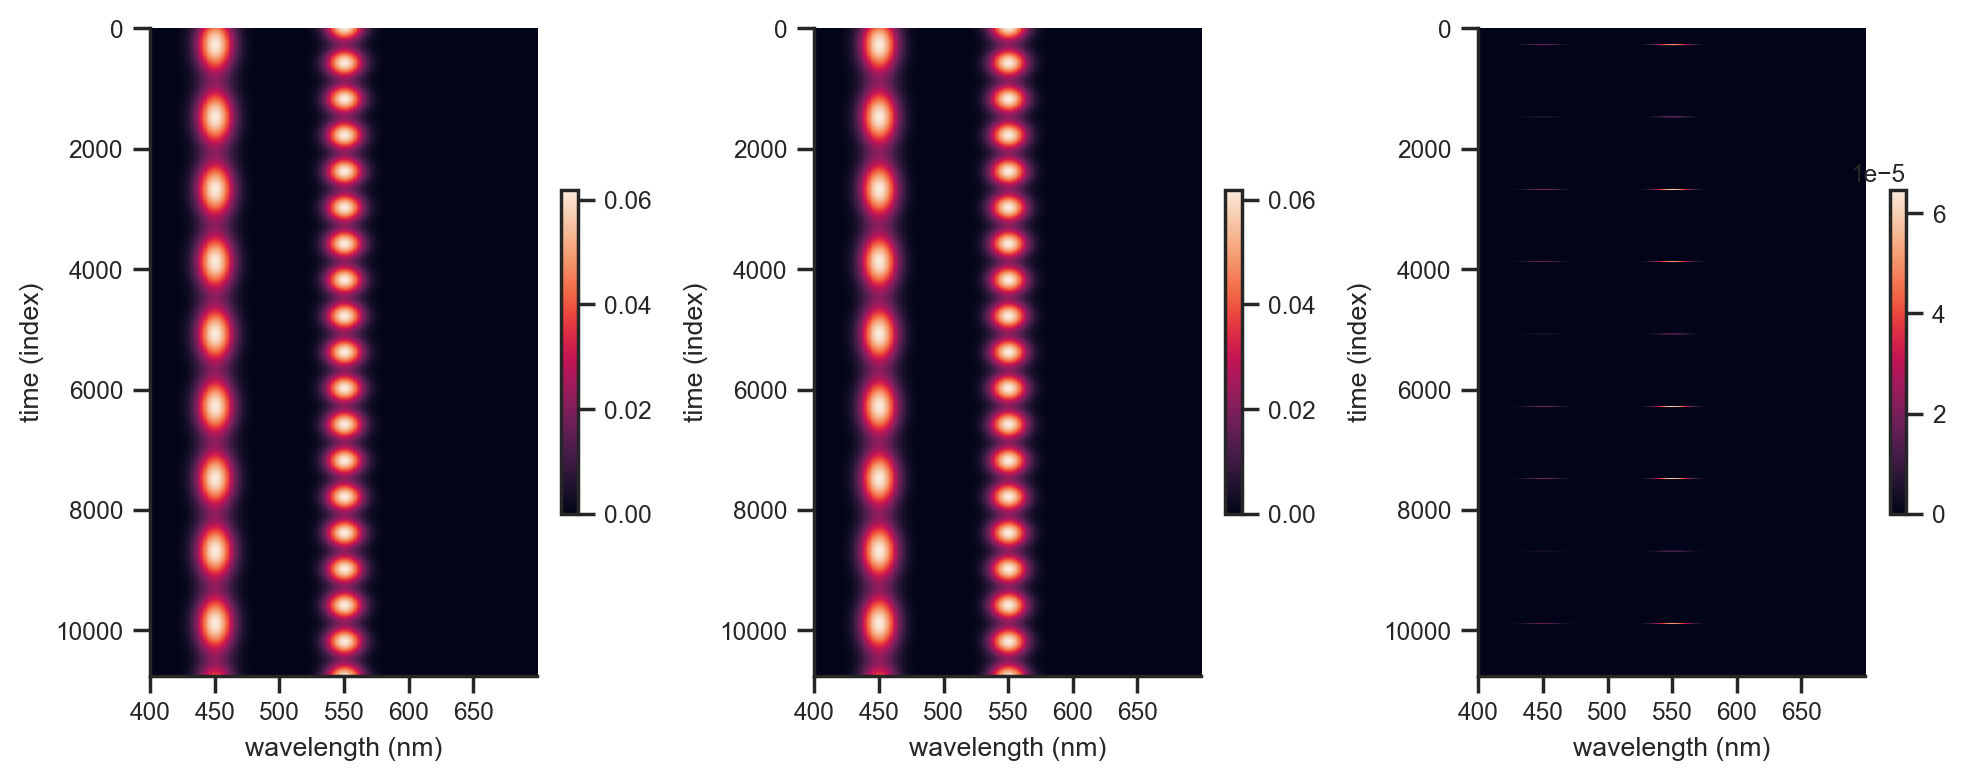

In [21]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(pltj[i],
                            interpolation='nearest',
                            aspect='auto'),
               ax=ax[i], shrink=0.5)
    ax[i].grid(False)
    ax[i].set(xlabel='wavelength (nm)', ylabel='time (index)')
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])
plt.tight_layout()

 - In conclusion, vanilla NMF has degenerate solutions, even for the above toy example. 
 - The residuals are low, but the components are not what we want (identifiability). 
 - We need to add problem-dependent biases.
 
 <p></p>

For laser noise vs indicator activity, there are a few different problems
 - The rough estimates of laser noise and indicator activity using single channel (EGFP only) can be obtained by averaging in different parts of the color spectrum
 - Even so the relative magnitudes of these components are different by orders of magnitude.
 - It is unclear what a general strategy to normalize the data is
 - Importantly, the laser noise is also separated in the frequency (fourier dual of time) space - this is not the case with indicators.
 - Ultimately, I am viewing it as a very different problem, for which I don't quite see how we'd do "better" than the heuristic approach to simply average the signal across relevant color spectrum.

In my view all of this is telling us to focus on building an NMF model from scratch where we can control the update rules and the biases, and attempt a proof of principle with the toy example/ single channel data (since we don't have multi-indicator data for now)